In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Jan 28 20:09:03 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0    48W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 289108
-rw-rw-r-- 1 scpark scpark    84663  1월 28 20:08 events.out.tfevents.1706440066.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7472764  1월 28 20:08 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 28 20:07 events.out.tfevents.1706439860.GPUSVR11
-rw-rw-r-- 1 scpark scpark 42197755  1월 28 20:00 events.out.tfevents.1706413012.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 20:00 save_283453
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:55 save_280000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:39 save_270000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:24 save_260000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:08 save_250000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:52 save_240000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:37 save_230000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:21 save_220000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:05 save_210000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:50 save_200000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:34 save_

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

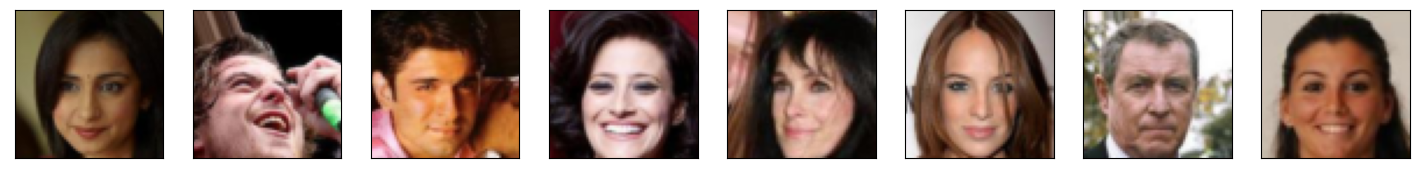

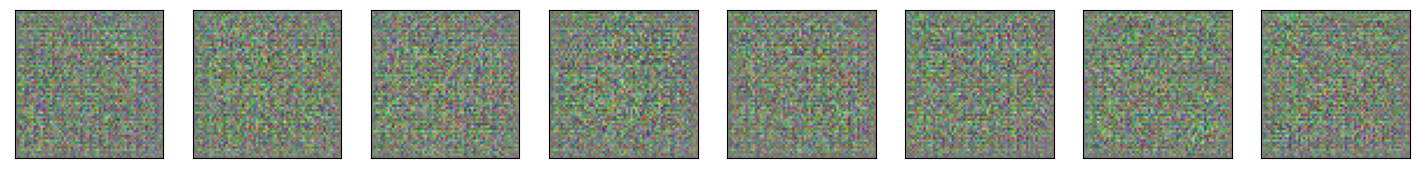

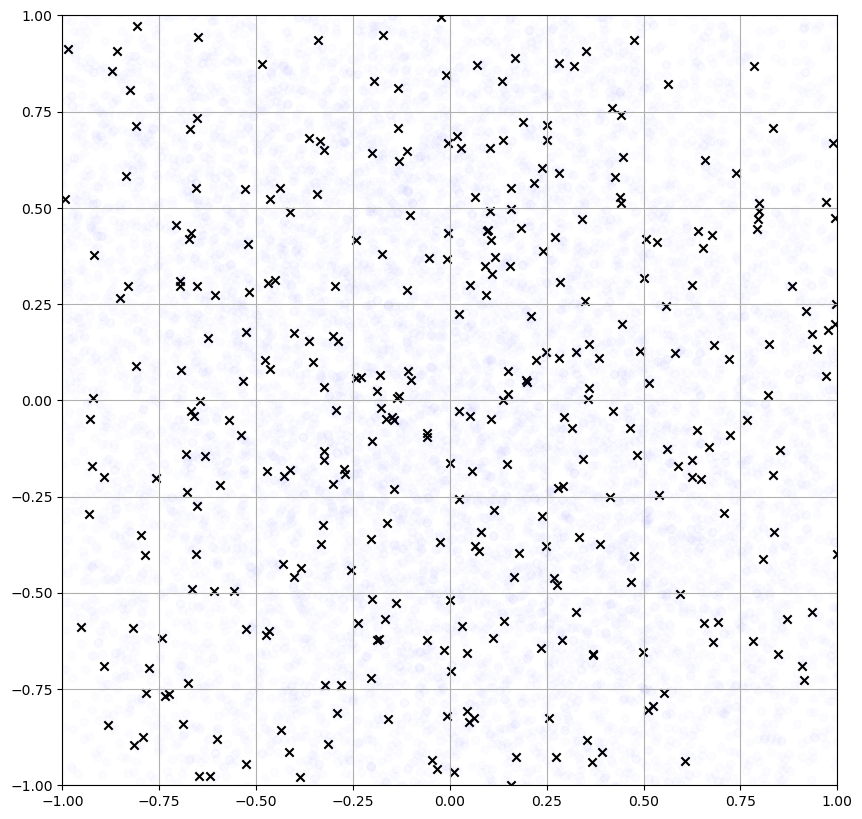

1
lse_loss 32.07416915893555
commit_loss 0.6348680257797241
recon_loss 0.09949516505002975
2
lse_loss 31.892803192138672
commit_loss 0.6262490153312683
recon_loss 0.10024340450763702
3
lse_loss 31.161903381347656
commit_loss 0.6064741611480713
recon_loss 0.08834759891033173
4
lse_loss 31.02825927734375
commit_loss 0.5965763330459595
recon_loss 0.09008558094501495
5
lse_loss 30.696609497070312
commit_loss 0.5859978199005127
recon_loss 0.08557649701833725
6
lse_loss 30.16494369506836
commit_loss 0.5723053216934204
recon_loss 0.07773815840482712
7
lse_loss 29.915117263793945
commit_loss 0.5613568425178528
recon_loss 0.0766756534576416
8
lse_loss 29.984779357910156
commit_loss 0.5516217350959778
recon_loss 0.07678665220737457
9
lse_loss 29.77301597595215
commit_loss 0.538293719291687
recon_loss 0.07504751533269882
10
lse_loss 29.861106872558594
commit_loss 0.5279631614685059
recon_loss 0.07111865282058716
11
lse_loss 29.623260498046875
commit_loss 0.5154019594192505
recon_loss 0.0682048648

lse_loss 13.342653274536133
commit_loss 0.31906408071517944
recon_loss 0.02067253738641739
91
lse_loss 12.957293510437012
commit_loss 0.31172633171081543
recon_loss 0.019449863582849503
92
lse_loss 12.655817031860352
commit_loss 0.30958670377731323
recon_loss 0.020972995087504387
93
lse_loss 12.824737548828125
commit_loss 0.30247828364372253
recon_loss 0.020904947072267532
94
lse_loss 12.315348625183105
commit_loss 0.30362436175346375
recon_loss 0.02233012020587921
95
lse_loss 12.70845890045166
commit_loss 0.30879735946655273
recon_loss 0.02214338630437851
96
lse_loss 12.152125358581543
commit_loss 0.30406251549720764
recon_loss 0.01944243535399437
97
lse_loss 12.863868713378906
commit_loss 0.313098281621933
recon_loss 0.021328847855329514
98
lse_loss 12.049293518066406
commit_loss 0.3007957637310028
recon_loss 0.019247157499194145
99
lse_loss 12.74245548248291
commit_loss 0.3136419653892517
recon_loss 0.020219188183546066
100
lse_loss 12.187605857849121
commit_loss 0.3025980293750763


lse_loss 11.406983375549316
commit_loss 0.2538301944732666
recon_loss 0.011615092866122723
178
lse_loss 11.294811248779297
commit_loss 0.2562808096408844
recon_loss 0.011017315089702606
179
lse_loss 11.301224708557129
commit_loss 0.2521432936191559
recon_loss 0.012340910732746124
180
lse_loss 11.36142349243164
commit_loss 0.25105682015419006
recon_loss 0.010195720009505749
181
lse_loss 11.54823112487793
commit_loss 0.2537497878074646
recon_loss 0.011697269976139069
182
lse_loss 11.399219512939453
commit_loss 0.24897649884223938
recon_loss 0.013117175549268723
183
lse_loss 11.280006408691406
commit_loss 0.2495983988046646
recon_loss 0.011576712131500244
184
lse_loss 11.664200782775879
commit_loss 0.26157256960868835
recon_loss 0.010191574692726135
185
lse_loss 11.347452163696289
commit_loss 0.24754811823368073
recon_loss 0.012388396076858044
186
lse_loss 11.673152923583984
commit_loss 0.24870285391807556
recon_loss 0.01126258447766304
187
lse_loss 11.243597030639648
commit_loss 0.251414

lse_loss 12.007822036743164
commit_loss 0.22820976376533508
recon_loss 0.009153827093541622
265
lse_loss 11.907657623291016
commit_loss 0.23045845329761505
recon_loss 0.008665482513606548
266
lse_loss 11.964088439941406
commit_loss 0.22518208622932434
recon_loss 0.00845356471836567
267
lse_loss 12.023111343383789
commit_loss 0.23082545399665833
recon_loss 0.00969480536878109
268
lse_loss 12.080196380615234
commit_loss 0.23225659132003784
recon_loss 0.008256502449512482
269
lse_loss 11.71963119506836
commit_loss 0.21798162162303925
recon_loss 0.00842477660626173
270
lse_loss 11.858057975769043
commit_loss 0.21927958726882935
recon_loss 0.008153598755598068
271
lse_loss 12.274091720581055
commit_loss 0.2289910912513733
recon_loss 0.008261118084192276
272
lse_loss 11.877304077148438
commit_loss 0.22000035643577576
recon_loss 0.0080424128100276
273
lse_loss 11.856744766235352
commit_loss 0.21790584921836853
recon_loss 0.008451398462057114
274
lse_loss 12.102166175842285
commit_loss 0.22744

352
lse_loss 12.932476997375488
commit_loss 0.2148619145154953
recon_loss 0.007428993936628103
353
lse_loss 12.870065689086914
commit_loss 0.2063925564289093
recon_loss 0.00693057756870985
354
lse_loss 12.88862419128418
commit_loss 0.21027517318725586
recon_loss 0.00693873967975378
355
lse_loss 12.902888298034668
commit_loss 0.2030835598707199
recon_loss 0.006524854805320501
356
lse_loss 13.02039909362793
commit_loss 0.20330309867858887
recon_loss 0.00663343770429492
357
lse_loss 12.862293243408203
commit_loss 0.2088605761528015
recon_loss 0.006999505218118429
358
lse_loss 12.91484546661377
commit_loss 0.20304304361343384
recon_loss 0.006852880120277405
359
lse_loss 13.029502868652344
commit_loss 0.2081080824136734
recon_loss 0.006379473023116589
360
lse_loss 12.919222831726074
commit_loss 0.21061232686042786
recon_loss 0.007393870037049055
361
lse_loss 13.176227569580078
commit_loss 0.20878662168979645
recon_loss 0.006321452558040619
362
lse_loss 12.865087509155273
commit_loss 0.20037

lse_loss 14.237016677856445
commit_loss 0.1902555227279663
recon_loss 0.006062974687665701
440
lse_loss 14.178110122680664
commit_loss 0.19095340371131897
recon_loss 0.00670607527717948
441
lse_loss 14.05885124206543
commit_loss 0.19240811467170715
recon_loss 0.00567223783582449
442
lse_loss 14.211519241333008
commit_loss 0.19597545266151428
recon_loss 0.006015200167894363
443
lse_loss 14.336902618408203
commit_loss 0.1889151632785797
recon_loss 0.005539126694202423
444
lse_loss 14.455339431762695
commit_loss 0.1984398066997528
recon_loss 0.005846360232681036
445
lse_loss 14.067878723144531
commit_loss 0.1868835836648941
recon_loss 0.005581158213317394
446
lse_loss 14.275309562683105
commit_loss 0.19061923027038574
recon_loss 0.005537407007068396
447
lse_loss 14.415678024291992
commit_loss 0.19317981600761414
recon_loss 0.005731196608394384
448
lse_loss 14.309656143188477
commit_loss 0.19440345466136932
recon_loss 0.005953430198132992
449
lse_loss 14.177648544311523
commit_loss 0.18349

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')